# Detecting COVID-19  in Lung CT Scans

## Genevieve Lyons, Amita Varma, Rebecca Youngerman

## Harvard T.H. Chan School of Public Health

## Introduction

### Background

COVID-19 is an illness caused by a virus that can spread from person to person. It is a respiratory illness that has spread across the world, throwing us all into lockdown. ([CDC Fact Sheet](https://www.cdc.gov/coronavirus/2019-ncov/downloads/2019-ncov-factsheet.pdf)).

Healthcare systems are testing citizens for COVID-19 primarily using polymerise chain reaction (PCR) testing. PCR tests are used to directly detect the presence of an antigen, but have a low sensitivity, about 70%. This means that the false negative rate is 30%, i.e., $P(T-|D+) = 0.3$ (where $T$ represents the testing results and $D$ represents the infection) ([Different paths to the same destination: screening for Covid-19](https://www.medicaldevice-network.com/features/types-of-covid-19-test-antibody-pcr-antigen/)). Additionally, testing kits are widely unavailable as we face shortages and production issues ([Coronavirus Testing Hampered by Disarray, Shortages, Backlogs](https://www.wsj.com/articles/coronavirus-testing-hampered-by-disarray-shortages-backlogs-11587328441)).

Some countries have turned to alternative methods to speed up COVID-19 diagnosing. One prominent option is diagnosing the condition via chest CT scans. A CT scan (computed tomography scan) combines x-rays to create a rotating image of organs, bones, tissues, etc. It shows more detail than a standard x-ray image. China, for example, has recommended using CT to diagnose COVID-19. A number of companies and researchers have created deep learning models to automate this task ([China uses AI in medical imaging to speed up COVID-19 diagnosis](https://www.bioworld.com/articles/433530-china-uses-ai-in-medical-imaging-to-speed-up-covid-19-diagnosis), [Correlation of Chest CT and RT-PCR Testing in Coronavirus Disease 2019 (COVID-19) in China: A Report of 1014 Cases](https://pubs.rsna.org/doi/10.1148/radiol.2020200642?)). 

However, guidelines in the United States discourage the use of CT scans as a diagnostic measure. There is a debate about whether it is appropriate in this context. Generally speaking, the consensus is that CT scans sacrifice specificity ($P(T-|D-)$) for improved sensitivity ($P(T+|D+)$) when compared to the PCR test. This is particularly troublesome when discerning between pneumonia and COVID-19 ([Can CT scans diagnose COVID-19? Experts argue for and against](https://www.medicalnewstoday.com/articles/ct-use-in-covid-19-diagnosis)). 

In this project, we will train a deep convolutional neural network to detect COVID-19 from lung CT scans. Because we believe the ramifications of a false negative outweigh those of a false positive, we will focus on improving sensitivity using our models. 

### Data Collection

We have collected a sample of lung CT scans for patients who were COVID-19 positive (n = 349) and COVID-19 negative (n = 397) from [COVID-CT-Dataset: a CT scan dataset about COVID-19](https://github.com/UCSD-AI4H/COVID-CT) (Zhao et al). The images are collected from COVID19-related papers from medRxiv, bioRxiv, NEJM, JAMA, Lancet, etc. CTs containing COVID-19 abnormalities are selected by reading the figure captions in the papers. All copyrights of the data belong to the authors and publishers of these papers.

Our sample is very small, with fewer than 800 total images (349 cases and 397 controls). Because of that, over the course of this project we strive to employ data augmentation and transfer learning methods to improve the generalizability of our model. Still, our model would be greatly benefited by the collection of additional data. As will be discussed in the Conclusions and Next Steps, we have reached out to various Harvard Chan affiliated epidemiologists and researchers who have expressed interest in our project and would have access to such data, but the timeline was too short for them to contribute for this paper. 

## Load the Data

In [1]:
## Imports ## 

import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import exposure

import tensorflow as tf
from tensorflow.keras import backend as K, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm

from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
#Check if there's a GPU available 
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(loss)+1)

    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, color = 'orange', label='Training Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, color = 'orange', label='Training Accuracy')
    plt.plot(epochs, val_acc, color = 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.show();

Load the image data:

In [6]:
data = []
file_list = []
y = []

for png in os.listdir("../data/CT_COVID"):
    pic = plt.imread("../data/CT_COVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(1)

for png in os.listdir("../data/CT_NonCOVID"):
    pic = plt.imread("../data/CT_NonCOVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(0)

In [7]:
metadata = pd.read_excel("../data/COVID-CT-MetaInfo.xlsx", header = None, names = ['file','patient','column3','note'])

Case and Control Counts:

In [8]:
print("Case and Control Counts: ")
print(pd.DataFrame(y, columns = ['Case']).groupby("Case").Case.count())

Case and Control Counts: 
Case
0    397
1    349
Name: Case, dtype: int64


In [9]:
metadata.head() #note: checked that these are in the same order as the file list; for covid-19 patients only 

,file,patient,column3,note
0,2020.01.24.919183-p27-132.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
1,2020.01.24.919183-p27-133.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
2,2020.01.24.919183-p27-134.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
3,2020.01.24.919183-p27-135.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
4,2020.02.10.20021584-p6-52%0.png,Patient 2,NaN,['Figure 1. A 50-year-old man with 2019 novel ...


### Using CT Scans to Identify COVID-19

To ensure that our findings were medically valid, we collaborated with a physician, (Dr. Christine Wu, Novant Health Family Medicine Residency in Cornelius NC), a radiologist, and referenced [Interpretation of CT signs of 2019 novel coronavirus (COVID-19) pneumonia](https://link.springer.com/content/pdf/10.1007/s00330-020-06915-5.pdf) (Wu et al). Through this background research and collaboration, we understand that ground glass opacity is the most common CT sign of COVID-19, although there are certainly others such as pulmonary consolidation. 

Ground glass opacity (GGO) is characterized by an area of increased attenuation in the lung on computed tomography (CT) with preserved bronchial and vascular markings. ([Radiopaedia](https://radiopaedia.org/articles/ground-glass-opacification-3?lang=us)) Said in terms that we as data scientists may understand, GGO is a sort of "haziness" that appears on one side of the lung. 

Let's look a few images to see what that means. Note that when reading a CT scan, we refer to the left/right direction with respect to the patient; so the "left lung" is on the right hand side of the image. 

Example Images with COVID: 


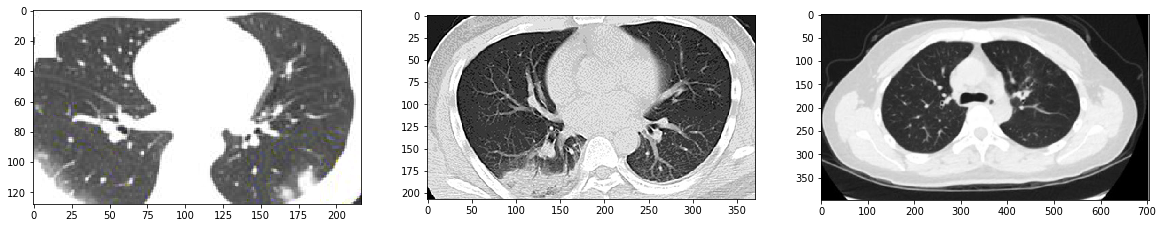

Example Images without COVID: 


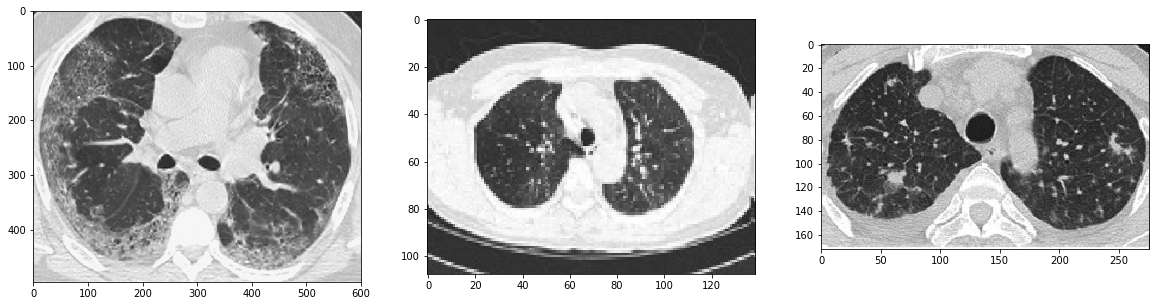

In [10]:
print("Example Images with COVID: ")
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(data[21], cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(data[190], cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(data[231], cmap = 'gray')
plt.show();

print("Example Images without COVID: ")
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(data[501], cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(data[609], cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(data[721], cmap = 'gray')
plt.show();

The first set of images are a few random COVID-19 positive images. You can see GGO in the first image on the bottom of the left lung, where there is some light haziness compared to the right lung. Similarly, in the second image, we can see GGO spreading across the entire left lung. The third image is the highest quality of the three and we can see GGO in both the right and left lungs, particularly near the bottom.

The second set of images are a few random COVID-19 negative images. In the first, we do not see GGO, although we do see interstitial lung disease or abnormalities. The second image appears to be a healthy set of lungs. In the third image, we do not see GGO but we do see a abnormal lung pathology that indicate that this patient is not completely healthy.

As is likely evident from the descriptions above, reading these CT scans is more an art than a science, and there is a very good reason that many people dedicate their lives to perfecting it. Our group members are in no way radiology professionals. When training these models to assist in clinical decision making, we want to make it clear that our intention is to do just that: assist and augment the decision making process, not replace it. 

A caveat that our collaborators and researched emphasized is that CT scans have the potential to be very sensitive, easily picking up GGO and other factors, but generally lack in specificity. The presence of GGO is not a foolproof indicator of COVID-19 -- in fact it could be indicative of any number of respiratory conditions. We cannot draw a medical conclusion without a holistic assessment of the patient and their symptoms. However, right now, in a time of pandemic, the probability that it indicates COVID-19 is greatly increased, particularly if the patient is also displaying symptoms. 

Another important insight from looking at these scans is that the image quality varies significantly between various CT scans. This is something that would normally be beneficial to the generalizability of our model, but given the small sample size, it certainly is problematic. Finally, the COVID-19 negative CT scans generally do not appear like they belong to "healthy" patients. Many of them appear to belong to smokers, as evidenced by pulmonary blebs, to individuals with cancer, as evidenced by nodules, or even have collapsed lungs. This data limitation makes sense: healthy people don't get CT scans. However, it's important to keep in mind when we consider the interpretability of our results. We want to ensure that we are finding GGO, not nodules, blebs, or other confounders. A great extension of this project, if the data were to become available, would be to train a model to discern between COVID-19 and unrelated pneumonia.

For our current purposes, however, we use the data that is available to us to train two convolutional neural networks to identify COVID-19 in patients using the available lung CT scans.

## Data Processing

Investigate the size of the images:

In [11]:
print("All images have different shapes, including # of channels: ")
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)
print(data[4].shape)

#Get a list of all the sizes
shape = []
for img in data:
    shape.append(img.shape)

print(pd.DataFrame([len(s) for s in shape], columns = ['len']).groupby('len').size()) #There are 2-D and 3-D images

print((pd.DataFrame([s[0] for s in shape], columns = ['height'])).describe()) #avg 302, min 61
print((pd.DataFrame([s[1] for s in shape], columns = ['width'])).describe()) #avg 425, min 115

All images have different shapes, including # of channels: 
(473, 627, 3)
(406, 572, 4)
(98, 115, 4)
(278, 417)
len
2     44
3    702
dtype: int64
            height
count   746.000000
mean    302.553619
std     145.210573
min      61.000000
25%     204.000000
50%     291.000000
75%     363.750000
max    1225.000000
             width
count   746.000000
mean    425.482574
std     188.546038
min     115.000000
25%     311.250000
50%     407.000000
75%     512.000000
max    1671.000000


All of the images need to be the same size. Use the average size of the image from the investigation above. Use high quality down-sampling filter to resize images. Also, turn all images to black and white.

In [12]:
image_dim = (300, 400) #use the averages for the dimensions

data_cleaned = []

for img in data:
    #First, take the mean of the 3rd dimension (channels) if it exists
    if len(img.shape) == 3:
        img = np.mean(img, axis = 2)
    
    #Using PIL Image processor, resize using high quality down-sampling filter 
    img = Image.fromarray(img)
    img = img.resize((image_dim[1], image_dim[0]), Image.ANTIALIAS)
    img = np.array(img)
    
    #Normalize image values
    img = img/255
    
    img[img > 1] = 1
    
    data_cleaned.append(img)

data_cleaned = np.array(data_cleaned)
data_cleaned = np.expand_dims(data_cleaned,axis = 3)

Take a look at a few images and confirm that we have not lost too much information.

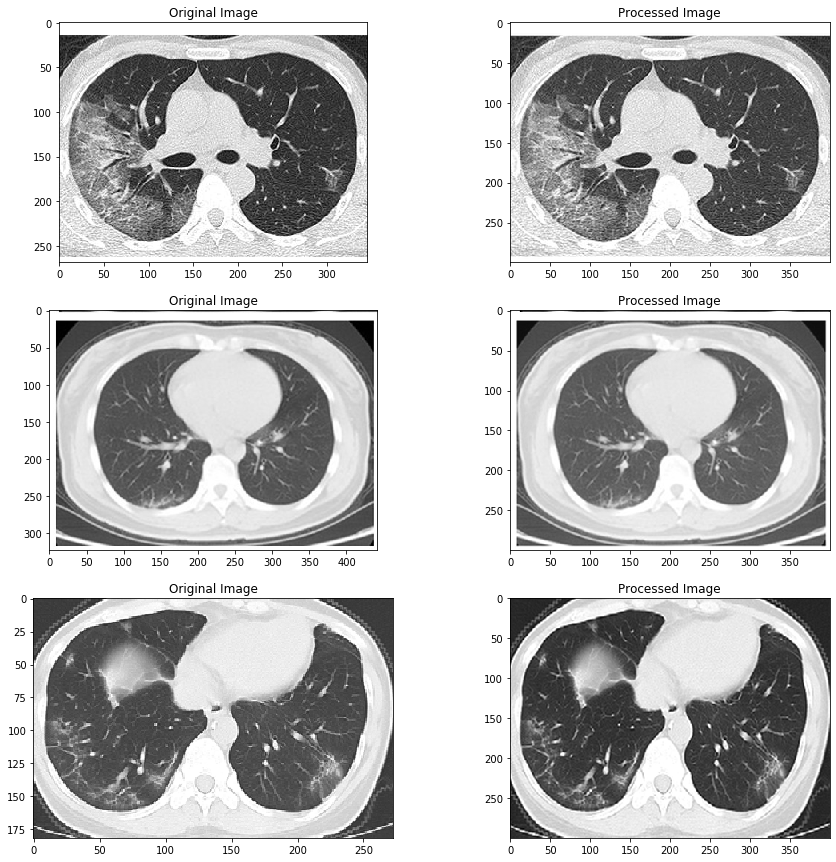

In [13]:
plt.figure(figsize = (15, 15))
plt.subplot(3,2,1)
plt.imshow(data[0], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,2)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[0]), cmap = 'gray')

plt.subplot(3,2,3)
plt.imshow(data[11], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,4)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[11]), cmap = 'gray')

plt.subplot(3,2,5)
plt.imshow(data[40], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,6)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[40]), cmap = 'gray')

plt.show();

Note that we can still see the ground glass opacities in the bottom left (image 1), middle right (image 2) and bottom left (image 3).

## Data Augmentation

First, split into the test and training set. We only want to augment the training data.

In [14]:
data_train, data_val, y_train, y_val = train_test_split(data_cleaned, np.array(y),\
                                                        train_size = 0.75, random_state = 10)

In [15]:
print(str((y_val.sum() / len(y_val) )*100) + "% of our validation data is cases")

47.05882352941176% of our validation data is cases


In [16]:
print("Training Sample Sizes: ")
print(data_train.shape)
print(y_train.shape)
print("Validation Sample Sizes: ")
print(data_val.shape)
print(y_val.shape)

Training Sample Sizes: 
(559, 300, 400, 1)
(559,)
Validation Sample Sizes: 
(187, 300, 400, 1)
(187,)


Because we have a very small sample size, we want to augment our available data. We will randomly flip the images horizontally and vertically, and rotate randomly (with a maximum of 15 degrees, so we don't change the lung structure too much).

In [17]:
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,  
    rotation_range = 15,
#     zca_whitening = True,
    fill_mode = 'nearest')

datagen.fit(data_train)

We also considered other data augmentation, such as zoom and shifting, but these methods did not seem appropriate given the structure of a lung CT scan, where all images will all be centered in the same location.

Let's take a look at our augmented images:

In [17]:
def visualize_augmented_images(image_num):
    img = data_train[image_num]
    img = img.reshape((1,300,400,1))

    i = 1
    plt.figure(figsize = (10,5))
    for batch in datagen.flow(img, batch_size=1):
        plt.subplot(2,2,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]), cmap = 'gray')
        i += 1
        if i % 5 == 0:
            break

    plt.show();

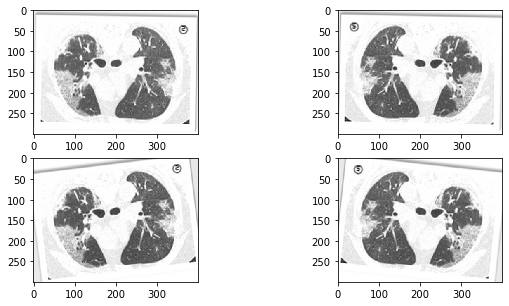

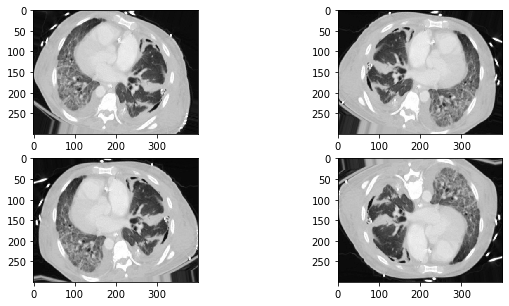

In [18]:
visualize_augmented_images(0)
visualize_augmented_images(30)

In [19]:
print("Training Sample Sizes: ")
print(data_train.shape)
print(y_train.shape)
print("Validation Sample Sizes: ")
print(data_val.shape)
print(y_val.shape)

Training Sample Sizes: 
(559, 300, 400, 1)
(559,)
Validation Sample Sizes: 
(187, 300, 400, 1)
(187,)


## Modelling

In this section, we train 2 models to detect COVID-19 in lung CT scans. The analysis, visualization, and discussion of our results can be found in the following section.

### Simple CNN

We first create a simple CNN. We use a similar architecture as we have used in the past for MNIST analyses, including 4 convolutional layers, with max pooling, a small dropout probability, and a sigmoid activation function. We use a dropout layer in order to curb overfitting.

In [20]:
model_simple = Sequential(name = 'Simple_CNN')
model_simple.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(300, 400, 1)))
model_simple.add(MaxPooling2D((2, 2), padding = 'same'))
model_simple.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model_simple.add(MaxPooling2D((2, 2), padding = 'same'))
model_simple.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model_simple.add(MaxPooling2D((2, 2)))
model_simple.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model_simple.add(MaxPooling2D((2, 2)))
model_simple.add(Flatten())
model_simple.add(Dropout(0.05))
model_simple.add(Dense(32, activation='relu'))
model_simple.add(Dense(1, activation='sigmoid'))

model_simple.summary()

model_simple.compile(optimizer = Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

Model: "Simple_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 400, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 200, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 200, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 128)       1

In [106]:
history_simple = model_simple.fit(
    datagen.flow(data_train, y_train, batch_size=16),
    epochs=10,
    validation_data=(data_val, y_val))

Train for 35 steps, validate on 187 samples
Epoch 1/10
35/35 [==============================] - 12s 329ms/step - loss: 0.6875 - accuracy: 0.5331 - val_loss: 0.6454 - val_accuracy: 0.6791
Epoch 2/10
35/35 [==============================] - 11s 311ms/step - loss: 0.6427 - accuracy: 0.6583 - val_loss: 0.6321 - val_accuracy: 0.6203
Epoch 3/10
35/35 [==============================] - 11s 305ms/step - loss: 0.6024 - accuracy: 0.6887 - val_loss: 0.6010 - val_accuracy: 0.6845
Epoch 4/10
35/35 [==============================] - 11s 303ms/step - loss: 0.5947 - accuracy: 0.6959 - val_loss: 0.6075 - val_accuracy: 0.5936
Epoch 5/10
35/35 [==============================] - 11s 310ms/step - loss: 0.5586 - accuracy: 0.7209 - val_loss: 0.5158 - val_accuracy: 0.7273
Epoch 6/10
35/35 [==============================] - 11s 308ms/step - loss: 0.5277 - accuracy: 0.7603 - val_loss: 0.5446 - val_accuracy: 0.7219
Epoch 7/10
35/35 [==============================] - 11s 308ms/step - loss: 0.5134 - accuracy: 0.75

We can see that this model yields 74% accuracy. 

In [107]:
#Save weights - only run this if you want to overwrite previous saved weights!
# model_simple.save_weights('models/simple_model')

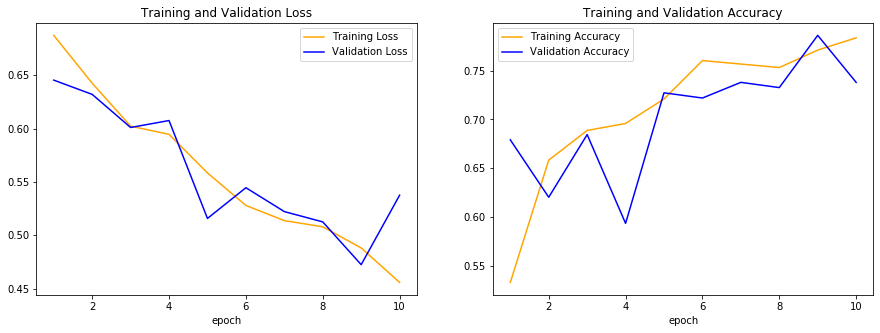

In [108]:
plot_training_history(history_simple)

In [23]:
#Load weights
model_simple.load_weights('models/simple_model')

### Pre-Trained Model Using VGG

Even with augemntation, our dataset is still relatively small, so we believed we could benefit from using a pretrained model for the convolutional base. [VGG16](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) is a convolutional neural network model created by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in [ImageNet](http://www.image-net.org/), which is a dataset of over 14 million images belonging to 1000 classes. 

Since the VGG model takes 3 channel RGB images and our images are single channel greyscale, we need to copy our images into 3 channels which is why we use the `Concatenate()` layer.
Additionally, we use `input_top = False` to load only the convolutional blocks, so we can customize the input and output layers as per our need.

In [24]:
# load VGG and concatenate input images into 3 channels 
img_input = Input(shape=(300, 400, 1))
vgg_model = VGG16(weights="imagenet", include_top=False, 
                  input_tensor=Concatenate()([img_input, img_input, img_input]))

The VGG model has 5 convolutional blocks.
Each block contains 2-3 convolutional layers and one max pooling layer. For our purposes, we froze the convolutional blocks, and trained our custom layers, which are 2 convolutional and maxpooling layers and a dropout and dense layer in the end to classify our images as cases or controls. This model outperforms the vanilla CNN with an increase to 84% accuracy.

In [25]:
# add a global spatial average pooling layer and a dense layer to classify 2 classes
x = vgg_model.output
x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.05)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# new model to train
pretrain_vgg_model = Model(inputs=vgg_model.input, outputs=predictions, name = "VGG_Pretrain")

# freeze many convolutional VGG layers: only train the last block
for layer in vgg_model.layers:
    layer.trainable = False

pretrain_vgg_model.compile(optimizer=Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
    
pretrain_vgg_model.summary()


Model: "VGG_Pretrain"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 400, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 300, 400, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 400, 64) 1792        concatenate[0][0]                
_______________________________________________________________________________________

In [87]:
#Train model
history_vgg = pretrain_vgg_model.fit(
    datagen.flow(data_train, tf.keras.utils.to_categorical(y_train), batch_size=16),
    epochs=10,
    validation_data=(data_val, tf.keras.utils.to_categorical(y_val)))

Train for 35 steps, validate on 187 samples
Epoch 1/10
35/35 [==============================] - 22s 628ms/step - loss: 0.6536 - accuracy: 0.6619 - val_loss: 0.4746 - val_accuracy: 0.7701
Epoch 2/10
35/35 [==============================] - 21s 587ms/step - loss: 0.4650 - accuracy: 0.7549 - val_loss: 0.4461 - val_accuracy: 0.7861
Epoch 3/10
35/35 [==============================] - 21s 589ms/step - loss: 0.4756 - accuracy: 0.7800 - val_loss: 0.5008 - val_accuracy: 0.7433
Epoch 4/10
35/35 [==============================] - 21s 588ms/step - loss: 0.4230 - accuracy: 0.8193 - val_loss: 0.4592 - val_accuracy: 0.7861
Epoch 5/10
35/35 [==============================] - 21s 591ms/step - loss: 0.4115 - accuracy: 0.8086 - val_loss: 0.4663 - val_accuracy: 0.7647
Epoch 6/10
35/35 [==============================] - 21s 589ms/step - loss: 0.4286 - accuracy: 0.8086 - val_loss: 0.4490 - val_accuracy: 0.7754
Epoch 7/10
35/35 [==============================] - 21s 588ms/step - loss: 0.3691 - accuracy: 0.83

In [88]:
#Save weights - only run this if you want to overwrite previous saved weights!
# pretrain_vgg_model.save_weights('models/VGG_model')

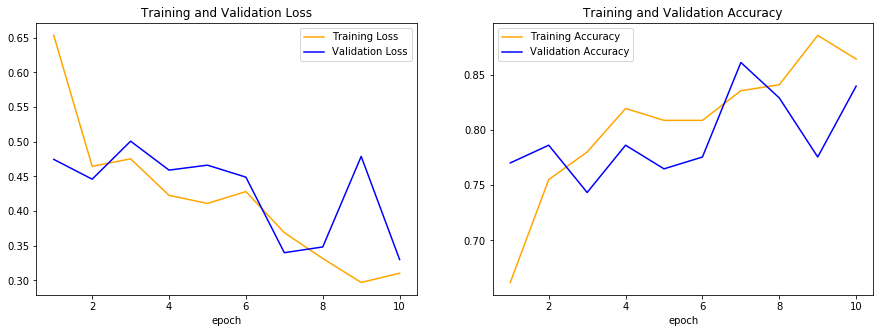

In [89]:
plot_training_history(history_vgg)

In [26]:
pretrain_vgg_model.load_weights('models/VGG_model')

## Analysis and Discussion of Predictions

In [24]:
### Plot the training and test ROC Curves ###
def plot_roc(model, categorical_ys):
    #Metrics for Testing Data
    if categorical_ys == 0:
        probs_test = model.predict(data_val)
    else:
        probs_test = model.predict(data_val)[:,1]
    preds_test = probs_test.reshape(-1)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_val, preds_test)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)

    #Metrics for Training Data
    if categorical_ys == 0:
        probs_train = model.predict(data_train)
    else:
        probs_train = model.predict(data_train)[:,1]
    preds_train = probs_train.reshape(-1)
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, preds_train)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)

    #Plot
    plt.title('ROC Curve')
    plt.plot(fpr_test, tpr_test, 'b', label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.plot(fpr_train, tpr_train, 'g', label = 'Train AUC = %0.2f' % roc_auc_train)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity: True Positive Rate')
    plt.xlabel('1-Specificity: False Positive Rate')
    plt.show();

    #Training and Test AUCs
    print('Test AUC = %0.4f' % roc_auc_test)
    print('Train AUC = %0.4f' % roc_auc_train)

In [25]:
def sensitivity_specificity(threshold_perc, probs_test, y_val):
    #Sensitivity
    print("The sensitivy at threshold percentage = " + str(threshold_perc) + " is : " + \
          str(round(np.sum(((probs_test >= threshold_perc) & (y_val == 1))) / np.sum((y_val == 1)),4)))
    #Specificity
    print("The specificity at threshold percentage = " + str(threshold_perc) + " is : " + \
          str(round(np.sum(((probs_test < threshold_perc) & (y_val == 0))) / np.sum((y_val == 0)),4)))

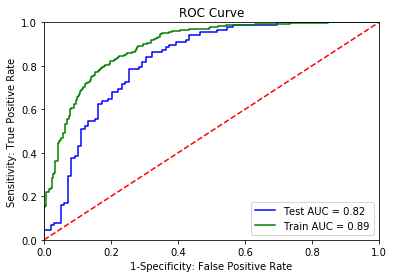

Test AUC = 0.8244
Train AUC = 0.8913


In [26]:
plot_roc(model_simple, categorical_ys = 0)

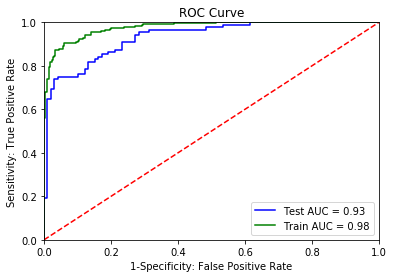

Test AUC = 0.9316
Train AUC = 0.9765


In [27]:
plot_roc(pretrain_vgg_model, categorical_ys = 1)

#### Comparison of results of 2 models

|Model             ||Validation Accuracy||Train AUC||Test AUC|
|------------------||-------------------||---------||--------|
|Simple CNN        ||        73.80%     ||0.891    ||0.824   |
|Pretrained network||          82.44%   ||0.977    ||0.932   |

The overall improvement in our model can be attributed to the fact that the pretrained VGG model has already learnt the low level features such as basic lines and shapes. Despite the differences between ImageNet data and our dataset, these features are common to almost all computer vision problems. When we stack additional layers on this model and train those, we adapt these low level features and build higher level features which are specific to our dataset. 

As we have better results for the VGG16 model, we can further analyse these results going forward. Specifically, we can look at the specificity and sensitivity for different classification thresholds, as is a common practice with training clinical models.

In [28]:
probs_test = pretrain_vgg_model.predict(data_val)[:,1]
preds_test = probs_test.reshape(-1)
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_val, preds_test)

# pd.DataFrame(pd.np.column_stack([threshold_test, tpr_test, 1-fpr_test]), 
#              columns = ['threshold','sensitivity','specificity'])

sensitivity_specificity(0.5, probs_test, y_val)
sensitivity_specificity(0.25, probs_test, y_val)

The sensitivy at threshold percentage = 0.5 is : 0.8523
The specificity at threshold percentage = 0.5 is : 0.8283
The sensitivy at threshold percentage = 0.25 is : 0.9432
The specificity at threshold percentage = 0.25 is : 0.7273


Since we are looking for this to be a screening test rather than a confirmation test for COVID, we are looking for our model to have a high sensitivity, i.e. we want to minimise false negatives at the risk of increased false positives. This is a decision we made based on the context of our problem. Screening for COVID is done so that people can take appropriate safety measures, hence creating a greater danger from false negatives rather than false positives.

The default cutoff of 0.5 gives us 0.85 and 0.83 for sensitivity and specificity. Upon further investigation, a threshold of 0.25 seems better for our task since it gives us a high sensitivity of 0.94.

## Visualizing the Model

**Visualizing Intermediate Activations**

First, we visualize some of the intermediate activation layers. We will use the `get_feature_maps` function from lab 6 to display the feature maps that are the output of the convolution and pooling layers in our network. These intermediate layers will show how an input is decomposed by different filters in the network. For all visualizations, we will be using our VGG pretrained model. This is because this model outperformed the vanilla CNN. We are also interested in viewing what the model "looks at" in our VGG pre-trained layers, and  what the intermediate activation layers look like within the last convolutional block that we trained.  

To begin, we will select layers to visualize. Here, we want to view:

    (1) A layer at the early stages of the VGG pretrain

    (2) A layer 
    
    (3) The final convolutional layer of the VGG pre-trained convolutional blocks.
    
    (4) The result of the first convolutional layer that we train
    
    (5) The result of the final convolutional layer

In [31]:
pretrain_vgg_model.layers[3].output

<tf.Tensor 'block1_conv2/Identity:0' shape=(None, 300, 400, 64) dtype=float32>

In [28]:
#Early in VGG
print(pretrain_vgg_model.layers[3].output);
#Halfway through VGG
print(pretrain_vgg_model.layers[10].output);
#Fully through VGG - Last Convolutional Layer
print(pretrain_vgg_model.layers[18].output);
#Beginning of our CNN
print(pretrain_vgg_model.layers[20].output);
#Last MaxPool of our CNN
print(pretrain_vgg_model.layers[22].output);

Tensor("block1_conv2/Identity:0", shape=(None, 300, 400, 64), dtype=float32)
Tensor("block3_conv3/Identity:0", shape=(None, 75, 100, 256), dtype=float32)
Tensor("block5_conv3/Identity:0", shape=(None, 18, 25, 512), dtype=float32)
Tensor("conv2d_4/Identity:0", shape=(None, 9, 12, 64), dtype=float32)
Tensor("conv2d_5/Identity:0", shape=(None, 5, 6, 128), dtype=float32)


We see the layer names (which correspond to our model summary) of the layers we have selected to visualize to verify that they correspond to the correct layers. 

In [33]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output]) 
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

We get the predictions for all validaiton data using the vgg model. 

In [34]:
#Use the predictd probabilities with the VGG model
vgg_probs_test = pretrain_vgg_model.predict(data_val)

Then, for one image, we show the intermediate layers. We decided to only take this step for one image as we would expect the layers to identify similar shapes/patterns for each image. 

Our Prediction is: 1
The true label is: 1
Prediction probability [0.16753086 0.83246917]


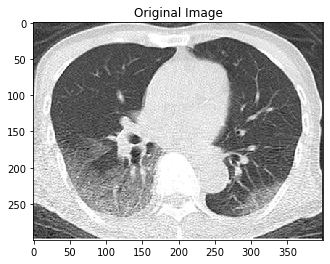

---------------
Beginning of VGG
---------------


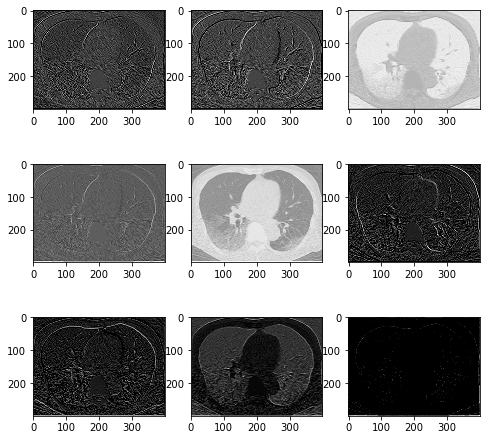

---------------
Middle of VGG
---------------


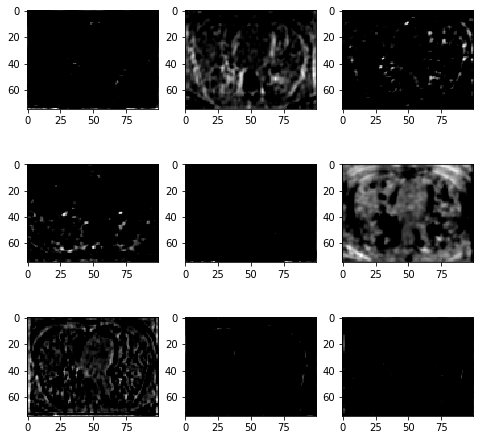

---------------
End of VGG
---------------


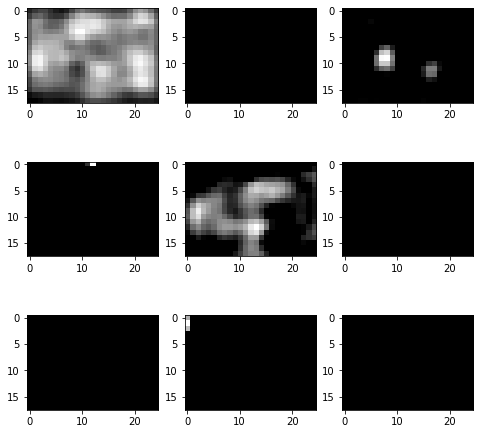

---------------
Beginning of trained portion
---------------


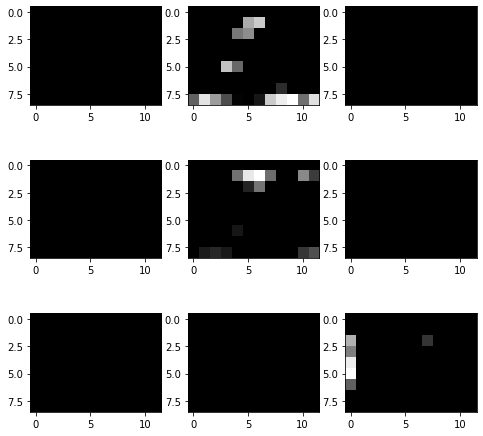

---------------
End of trained portion
---------------


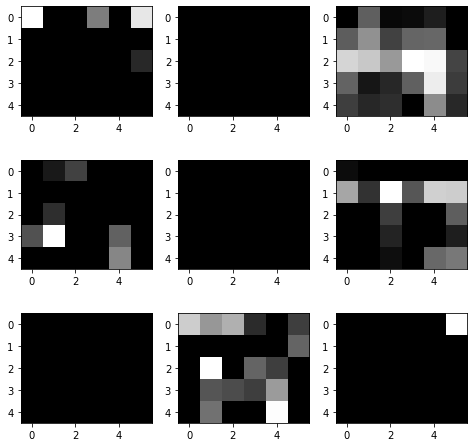

In [40]:
#Just show correctly classified
image_id = 21

early_vgg = get_feature_maps(pretrain_vgg_model, 3, data_val[image_id])
middle_vgg = get_feature_maps(pretrain_vgg_model, 10, data_val[image_id])
end_vgg = get_feature_maps(pretrain_vgg_model, 18, data_val[image_id])
beginning_simpCNN = get_feature_maps(pretrain_vgg_model, 20, data_val[image_id])
end_simpCNN = get_feature_maps(pretrain_vgg_model, 22, data_val[image_id])

fig, ax = plt.subplots()
img = np.squeeze(img)
    
ax.imshow(img + 0.5, cmap='gray')
label = y_val[image_id]
    
ax.set_title('Original Image')

img = data_val[image_id,:,:,:]
img_batch = (np.expand_dims(img,0))
predictions_single = pretrain_vgg_model.predict(img_batch)
print(f'Our Prediction is: {np.argmax(predictions_single[0])}') 
print("The true label is:", label)

print("Prediction probability", vgg_probs_test[image_id])
    
plt.show();
    
f, ax = plt.subplots(3,3, figsize=(8,8))
print("---------------")
print("Beginning of VGG")
print("---------------")
for i, axis in enumerate(ax.ravel()):
    axis.imshow(early_vgg[i], cmap='gray')
plt.show();


f, ax = plt.subplots(3,3, figsize=(8,8))
print("---------------")
print("Middle of VGG")
print("---------------")
for i, axis in enumerate(ax.ravel()):
    axis.imshow(middle_vgg[i], cmap='gray')
plt.show();

f, ax = plt.subplots(3,3, figsize=(8,8))
print("---------------")
print("End of VGG")
print("---------------")
for i, axis in enumerate(ax.ravel()):
    axis.imshow(end_vgg[i], cmap='gray')
plt.show();

f, ax = plt.subplots(3,3, figsize=(8,8))
print("---------------")
print("Beginning of trained portion")
print("---------------")
for i, axis in enumerate(ax.ravel()):
    axis.imshow(beginning_simpCNN[i], cmap='gray')
plt.show();
    
    
f, ax = plt.subplots(3,3, figsize=(8,8))
print("---------------")
print("End of trained portion")
print("---------------")
for i, axis in enumerate(ax.ravel()):
    axis.imshow(end_simpCNN[i], cmap='gray')
plt.show();

We see the early VGG layer identifying the edges of the lungs. At this stage, the activations are retaining almost all of the information from the original image. The images become more and more abstact as we move through the layers. The later layers begin to pick out specific features of the image - like GGOs or other abnormalities.

We also see greater sparsity as we move through the layers. In our early VGG layer, almost every filter is activated by the input image. In the following layers, more and more filters are blank as the pattern encoded by that filter isn't found in the input image. Overall, these images demonstrate that activations of layers later in the model carry less information about the specific CT scan (our input), and more information about the target (is this a COVID+ patient or COVID-patient). 


**Heatmaps of Class Activation - GradCam and Saliency Maps**

We will now use heatmaps to show which parts of an image lead our network to its classification decision. We are familiar with some visualization methods from class - GradCam and Saliency Maps, which will help us here. Using the output feature map, Grad-CAM ([Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)) weights every channel in the feature map by the gradient of the class with respect to that channel. To the human eye, we end up seeing heatmaps that demonstrate what parts of the image most heavily play into the network's prediction. 

Saliency maps ([Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)) are described as a topological representation of unique feature of an image. These maps represent "the conspicuity— or ‘saliency’—at every location in the visual field" ([What are Sliency Maps in Deep Learning](https://analyticsindiamag.com/what-are-saliency-maps-in-deep-learning/)). More colloquially, conspicuity is a property of being clearly discernable. These maps will help us to see what is distinctive to the network about each image. 

As we try to understand the features that motivate our network's classifications, we will use four images: two that are true COVID-19 positive patients and two that are true COVID - patients. We will see an example of a correct and incorrect prediction for each class.

We use a loop to find our 4 images that meet our criteria. This allows us to know what every validation image's true label is, how our model classified it, and what probability it was classified with. We selected a few to visualize using these lists.

In [44]:
cor = 0
inc = 1

#these labels are based on TRUE values
#positive, correctly identified
correct_positive = []
#positive, labeled as negative
incorrect_positive = []
#negative, correctly identified
correct_negative = []
#negative, labeled as positive
incorrect_negative = []

for i in range(len(data_val)):

#2 - very last MaxPooling layers
#5 - first original
#6 - last vgg
    imageid=i
    
    img = data_val[imageid,:,:,:]
    img_batch = (np.expand_dims(img,0))
#     print(f'Our Prediction is:', np.argmax(vgg_probs_test[i]))
    # prediction =  pretrain_vgg_model.predict(data_val[imageid])
    label = y_val[imageid]
#     print("The true label is:", label)
    
#     print("Prediction probability for [0,1]:", vgg_probs_test[i])

  # correctly classified
    if np.argmax(vgg_probs_test[i]) == label:
        if label == 1:
            correct_positive.append(i)
            correct_positive.append(vgg_probs_test[i][1])
        if label == 0:
            correct_negative.append(i)
            correct_negative.append(vgg_probs_test[i][0])
        cor +=1
    #incorrectly classified
    else:
        #truly positive
        if label == 1:
            incorrect_positive.append(i)
            incorrect_positive.append(vgg_probs_test[i][0])
        #truly negative
        if label == 0:
            incorrect_negative.append(i)
            incorrect_negative.append(vgg_probs_test[i][1])
        inc+=1

print("Final precent correct", cor/(cor+inc))
print("Final precent correct", inc/(cor+inc))
print("Number of images", (cor+inc))

print("Those correctly labeled positive, with associated probabilities:")  
print()
print(correct_positive)
print()

print("Those incorrectly labeled - true positive, labeled negative, with associated probabilities:")  
print()
print(incorrect_positive)
print()

print("Those correctly labeled negative, with associated probabilities:")  
print()
print(correct_negative)
print()

print("Those incorrectly labeled - true negative, labeled positive, with associated probabilities:") 

print()
print(incorrect_negative)
print()

Final precent correct 0.8723404255319149
Final precent correct 0.1276595744680851
Number of images 188
Those correctly labeled positive, with associated probabilities:

[0, 0.9708943, 1, 0.9974952, 5, 0.5928355, 12, 0.98766553, 14, 0.9929819, 15, 0.9848045, 16, 0.98829633, 21, 0.83246917, 23, 0.9642085, 29, 0.9049855, 31, 0.97551763, 32, 0.77793384, 35, 0.7306068, 36, 0.9092115, 42, 0.59869045, 43, 0.966227, 45, 0.8976008, 46, 0.9802791, 47, 0.8256554, 51, 0.97828954, 61, 0.977102, 64, 0.9099439, 68, 0.53954524, 69, 0.9947582, 71, 0.9882013, 72, 0.8314102, 74, 0.9958924, 76, 0.9774072, 78, 0.50163877, 82, 0.9941725, 85, 0.9647105, 88, 0.91501653, 90, 0.5550704, 91, 0.6401833, 93, 0.9916646, 95, 0.6856269, 96, 0.89738727, 97, 0.8371948, 99, 0.51392305, 101, 0.9304065, 102, 0.9535566, 103, 0.993658, 104, 0.9916449, 106, 0.81078446, 107, 0.78894746, 108, 0.95735097, 111, 0.9560866, 117, 0.7925024, 118, 0.66690505, 119, 0.73616934, 123, 0.9463802, 124, 0.99419373, 125, 0.8731327, 131, 0.80

Let's pick

**True COVID-19 Positive:**

Correct: 21 (99.8% confident)

Incorrect: 0 (76.6% confident)



**True COVID-19 Negative:**

Correct: 49 (99% confident)

Incorrect: 50 (68% confident)

Now we will look at these images with Grad-CAM and Saliency Maps.

In [36]:
def og_sal_grad(image_id):
    #Define loss depending on whether classified as + or -
    loss = lambda x: K.mean(x[:, np.argmax(vgg_probs_test[image_id])])
    
    # Define modifier to replace a softmax function of the last layer to a linear function.
    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear

    # Create Saliency object
    saliency = Saliency(pretrain_vgg_model, model_modifier)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss, data_val[image_id].astype(float), smooth_samples=20)
    saliency_map = normalize(saliency_map)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

    img = data_val[image_id,:,:,:]
    img_batch = (np.expand_dims(img,0))

    # from matplotlib import cm
    # from tf_keras_vis.gradcam import Gradcam

    # Create Gradcam object
    gradcam = Gradcam(pretrain_vgg_model, model_modifier)

    # Generate heatmap with GradCAM
    cam = gradcam(loss, img_batch.astype(float))
    cam = normalize(cam)


    #Plot
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(np.squeeze(data_val[image_id]), cmap = 'gray')
    plt.subplot(1,3,2)
    plt.title("Saliency Map")
    plt.imshow(saliency_map[0], cmap='YlOrBr');
    plt.subplot(1,3,3)

    
    plt.title("GradCAM")
    for i in range(len(cam)):
        heatmap = np.uint8(tf.cast(cm.jet(cam[i])[..., :3] * 255, tf.float32))
        plt.imshow(np.squeeze(img))
        plt.imshow(heatmap, cmap='YlOrBr', alpha=0.6)
    
    print("Predicted Probability for Class: " + str(np.max(vgg_probs_test[image_id])))

**COVID+, Correctly Classified**

Predicted Probability for Class: 0.99419373


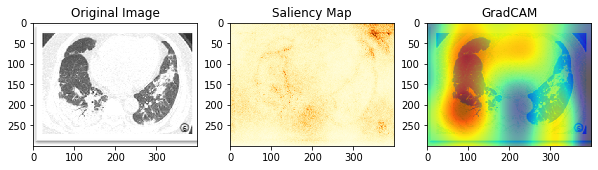

In [37]:
og_sal_grad(21)

With the correctly classified image, we see the ground glass opacity (GGO) being strongly identified with this GradCAM visualization. The right lung (remember, this would be on our left in the image) clearly  has this haziness toward the bottom, where we see GradCAM lighting up. The Saliency Map indicates that the upper left corner of the image is also distinctive. This could speak to the model having some difficulty with varying image boundaries, like this dark upper right corner. 

**COVID+, Incorrectly Classified**

Predicted Probability for Class: 0.76654613


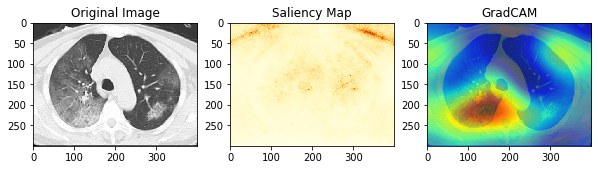

In [41]:
og_sal_grad(0)

Interestingly, we also see GradCAM picking up the GGO in this COVID positive patient, despite making an incorrect prediction. We might extrapolate that what this "means" the model was seeing were other features of the lungs. Perhaps it identified other unhealthy lungs that were not COVID+ and thought that this pair would fall into that category as the right lung has some additional white spots. We also see with the saliency map that again the boundary that goes black is picked out. 

**COVID-, Correctly Classified**

Predicted Probability for Class: 0.9974154


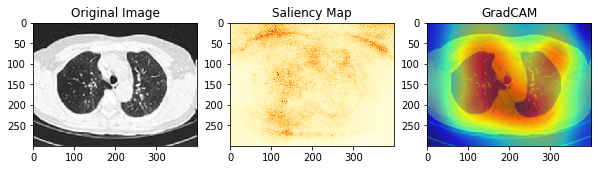

In [39]:
og_sal_grad(49)

This COVID negative patient that was correctly identified has hot spots from GradCAM all over the lungs. This may indicate that the model is looking over the entire organ, but not seeing any GGO that might indicate COVID+. This is also an example where the lungs do not have other notable abnormalities. This is a good sign - that a healthy lung (at least this one) will not be classified as COVID+ just because it does not have other abnormalities. The saliency map here is still lit up around the black edges, but we do see more identification throughout the lung. We may interpret this as a distinction of a wholely healthy lung that does not have abnormalities.  

**COVID-, Incorrectly Classified**

Predicted Probability for Class: 0.68019164


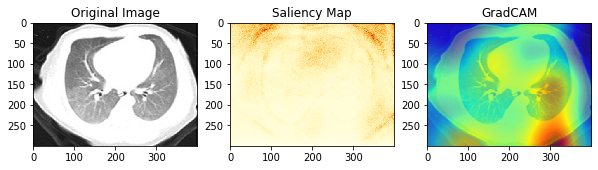

In [42]:
og_sal_grad(50)

This COVID negative patient was incorrectly classified as COVID positive. Based on the GradCAM image, it seems that the surrounding area of the lung may have been misinterpreted as GGO. Instead of indicating more focus on the entire lung as we saw on the correct classification of a negative patient, the model focused in on one section of the CT more pointedly that may have been mis-read as a COVID+ indicator.  

## Conclusion and Next Steps

Overall, our model fairly successfully identified COVID+ patients with a potential for a high sensitivity of 94% at a 25% threshold. With more training data, we feel that the model could have improved this performance by better learning what differentiates COVID+ patients from others, especially differentiating other diseased lungs. We felt that it was important to prioritize a high sensitivity in order to avoid false negatives for patients. With the aid of trained radiologists, a further developed version of models similar to ours has the potential to greatly improve COVID-19 detection.

There have been promising results for similar CT-classification tasks ([Fast and fully-automated detection and segmentation of pulmonary nodules in thoracic CT scans using deep convolutional neural networks](https://www.sciencedirect.com/science/article/abs/pii/S0895611118305366)). As previously stated, we advocate for models like ours as an aid, and not a replacement, to radiologists ([AI development in your radiology department - Seven simple steps](https://epos.myesr.org/esr/viewing/index.php?module=viewing_poster&task=&pi=147732)). We conclude that deep neural networks are a promising approach to classifying COVID-19 patients based on CT scans. CT scans may be especially helpful in classifying COVID-19 in those who are high risk due to respiratory illness, as training a successful CT-classification model must involve the differentiation of COVID from other conditions. 

Our next steps would begin with increasing our training data. As recommended by this projects advisor, Dr.Mauricio Santillana, we reached out to several faculty within the Department of Epidemiology at the Harvard T.H. Chan School of Public Health. We were met with positive, excited responses, but due to time constraints were unable to access other CT data being used for research through the university and beyond. 

Additionally, we have investigated the use of more relevant pre-trained networks beyond VGG, specifially through [NiftyNet](https://niftynet.io/). NiftyNet is an open source convolutional neural net platform designed for sharing networks and pre-trained models. This platform, run by a consortium of reputable biomedical institutions (BMEIS -- School of Biomedical Engineering and Imaging Sciences, King's College London; WEISS -- Wellcome EPSRC Centre for Interventional and Surgical Sciences, UCL; CMIC -- Centre for Medical Image Computing, UCL; HIG -- High-dimensional Imaging Group, UCL) contains many pre-trained models built with medical imaging data using the NiftyNet framework. Unfortunately, current implementation was not directly applicable to this project as the most relevant pre-trained models were not training on CT scans of lungs. Additionally, the development team for NiftyNet has shifted its focus to [MONAI](https://monai.io/), a simlilar project that is PyTorch-based and has contributors at Stanford, NVIDIA, and Massachusetts General Hospital & Brigham and Women's Center for Clinical Data Science. With added time to develop this project, we would investigate a shift to using the MONAI platform to include more medical imaging-focused pre-training. 

## References

1. [CDC Fact Sheet](https://www.cdc.gov/coronavirus/2019-ncov/downloads/2019-ncov-factsheet.pdf)
2. [Different paths to the same destination: screening for Covid-19](https://www.medicaldevice-network.com/features/types-of-covid-19-test-antibody-pcr-antigen/)
3. [Coronavirus Testing Hampered by Disarray, Shortages, Backlogs](https://www.wsj.com/articles/coronavirus-testing-hampered-by-disarray-shortages-backlogs-11587328441)
4. [China uses AI in medical imaging to speed up COVID-19 diagnosis](https://www.bioworld.com/articles/433530-china-uses-ai-in-medical-imaging-to-speed-up-covid-19-diagnosis)
5. [Correlation of Chest CT and RT-PCR Testing in Coronavirus Disease 2019 (COVID-19) in China: A Report of 1014 Cases](https://pubs.rsna.org/doi/10.1148/radiol.2020200642?)
6. [Can CT scans diagnose COVID-19? Experts argue for and against](https://www.medicalnewstoday.com/articles/ct-use-in-covid-19-diagnosis)
7. [COVID-CT-Dataset: a CT scan dataset about COVID-19](https://github.com/UCSD-AI4H/COVID-CT)
8. [Interpretation of CT signs of 2019 novel coronavirus (COVID-19) pneumonia](https://link.springer.com/content/pdf/10.1007/s00330-020-06915-5.pdf)
9. [Radiopaedia](https://radiopaedia.org/articles/ground-glass-opacification-3?lang=us)
10. [VGG16](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
11. [ImageNet](http://www.image-net.org/)
12. [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
13. [Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)
14. [What are Saliency Maps in Deep Learning](https://analyticsindiamag.com/what-are-saliency-maps-in-deep-learning/)
15. [Fast and fully-automated detection and segmentation of pulmonary nodules in thoracic CT scans using deep convolutional neural networks](https://www.sciencedirect.com/science/article/abs/pii/S0895611118305366)
16. [AI development in your radiology department - Seven simple steps](https://epos.myesr.org/esr/viewing/index.php?module=viewing_poster&task=&pi=147732)
17. [NiftyNet](https://niftynet.io/)
18. [MONAI](https://monai.io/)